In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import h5py
import shutil
from tqdm import tqdm

import numpy as np

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

import powerbox as pbox

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 0. Get the files

In [12]:
! ls /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache

fc_xray_128_LX_run2  fc_xray_128_zf0002_sf100  fc_xray_128_zf0002_sf50


In [21]:
ddir = '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/fc_xray_128_zf0002_sf100'
#ddir = '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/fc_xray_128_LX_run2'

In [22]:
flist = [f for f in os.listdir(ddir) if f.startswith('Ts')]
zlist = []
for f in tqdm(flist):
    with h5py.File(ddir + '/' + f, 'r') as hf:
        zlist.append(hf.attrs['redshift'])

pickle.dump((flist, zlist), open(f'{ddir}/flist_zlist_Ts.p', 'wb'))

100%|██████████| 102/102 [00:10<00:00, 10.03it/s]


In [23]:
flist, zlist = pickle.load(open(f'{ddir}/flist_zlist_Ts.p', 'rb'))
is_LX = False
if is_LX:
    z_target = np.sort(zlist)[1]
    i = np.argmin(np.abs(zlist - z_target))
else:
    i = np.argmin(zlist)
print(zlist[i])
print(flist[i])

5.1211957994
TsBox_03ffb798e5bcdb8d2f914b5563902935_r54321.h5


In [24]:
shutil.copyfile(f'{ddir}/{flist[i]}', f'./TsBox_fc_xray_zf0002_z{zlist[i]}.h5')

'./TsBox_fc_xray_zf0002_z5.1211957994.h5'

In [25]:
! ls .

IonizedBox_fc_xray_LX_z5.1210857802.h5
IonizedBox_fc_xray_zf0002_z5.1211957994.h5
TsBox_fc_xray_LX_z5.1210857802.h5
TsBox_fc_xray_zf0002_z5.1211957994.h5
xray-comp.ipynb


## 1. Load fields

In [2]:
# with h5py.File('IonizedBox_fc_xray_LX_z5.1210857802.h5') as hf:
#     xe_box_pc = hf['IonizedBox']['xH_box'][()]
# with h5py.File('IonizedBox_fc_xray_zf0002_z5.1211957994.h5') as hf:
#     xe_box_dc = hf['IonizedBox']['xH_box'][()]
with h5py.File('TsBox_fc_xray_LX_z5.1210857802.h5') as hf:
    xe_box_pc = hf['TsBox']['x_e_box'][()]
with h5py.File('TsBox_fc_xray_zf0002_z5.1211957994.h5') as hf:
    xe_box_dc = hf['TsBox']['x_e_box'][()]
with h5py.File('TsBox_fc_xray_LX_z5.1210857802.h5') as hf:
    Tk_box_pc = hf['TsBox']['Tk_box'][()]
with h5py.File('TsBox_fc_xray_zf0002_z5.1211957994.h5') as hf:
    Tk_box_dc = hf['TsBox']['Tk_box'][()]

In [23]:
# power spectra
xe_p_k_pc, k_bins = pbox.get_power(xe_box_pc, 256)
xe_p_k_dc, k_bins = pbox.get_power(xe_box_dc, 256)
Tk_p_k_pc, k_bins = pbox.get_power(Tk_box_pc, 256)
Tk_p_k_dc, k_bins = pbox.get_power(Tk_box_dc, 256)

/tmp/ipykernel_3118180/1231700204.py:49: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.17, hspace=0.05)


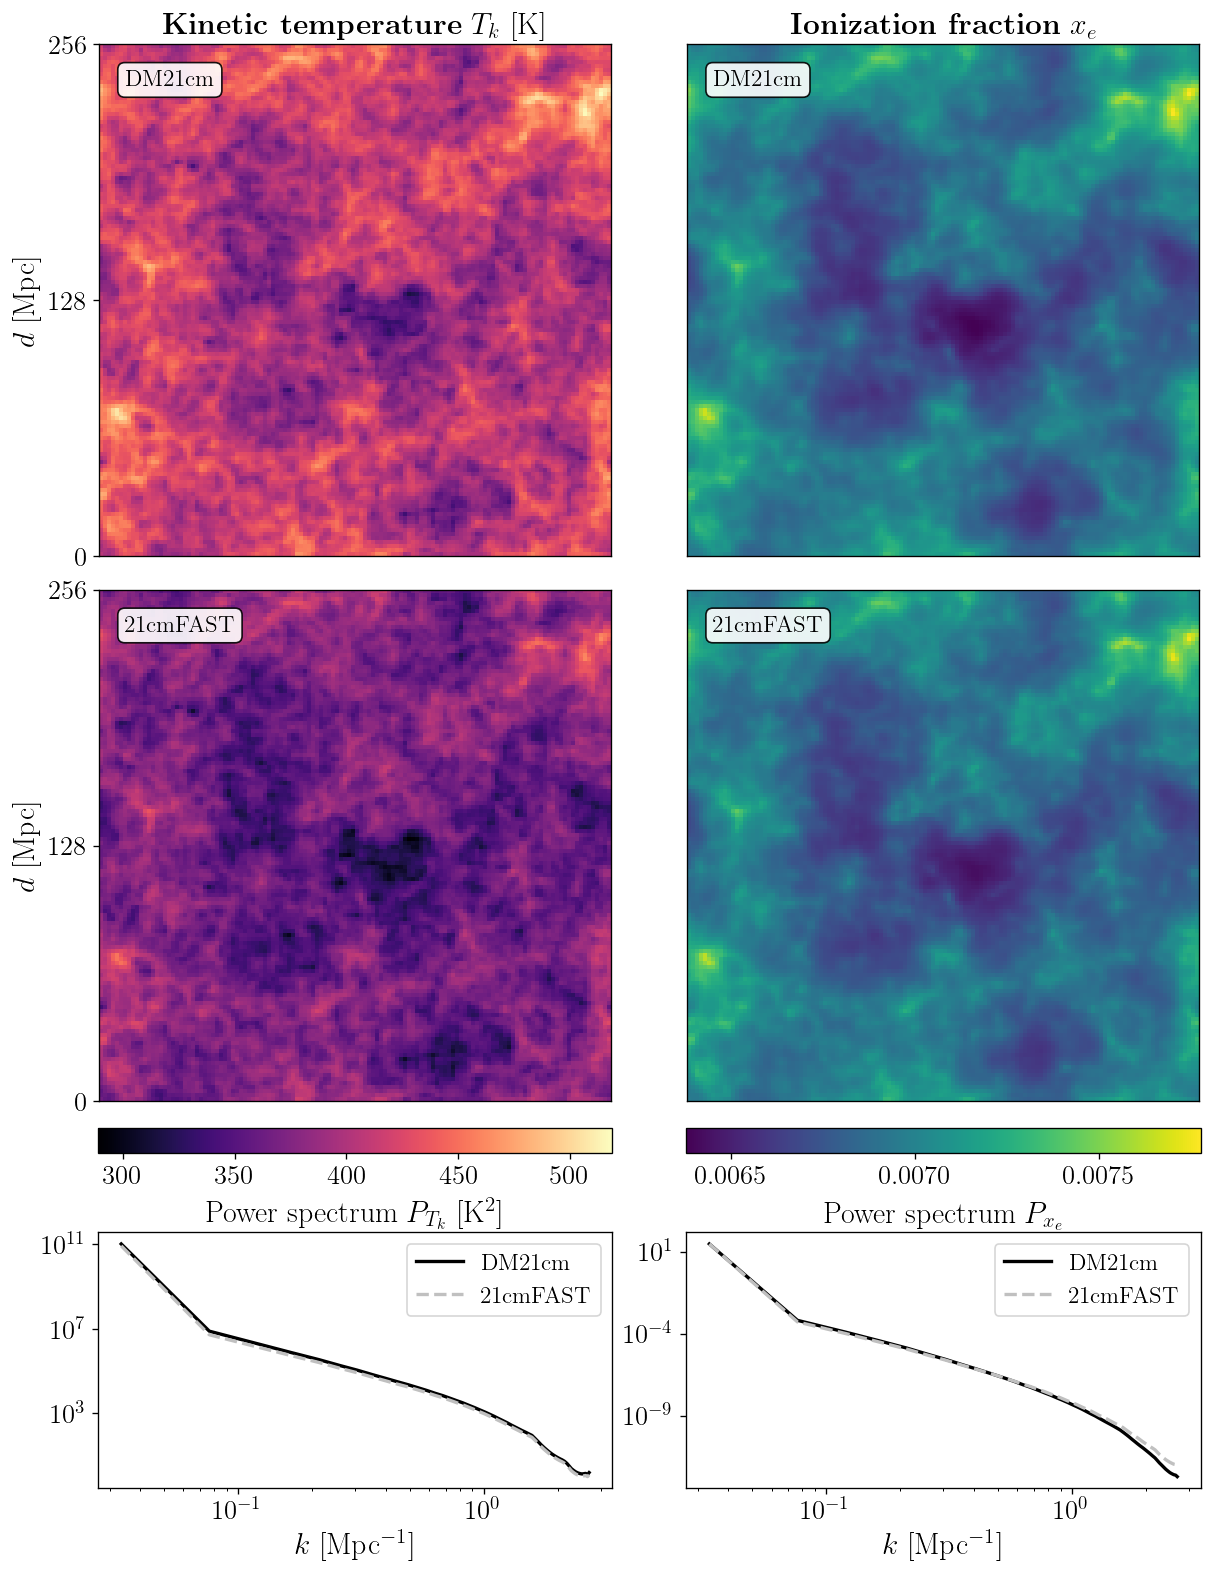

In [60]:
bbox_props = dict(boxstyle='round', facecolor='white', alpha=0.9)
text_style = dict(fontsize=14, va='top', ha='left', bbox=bbox_props)
dc_style = dict(ls='-', color='k', lw=2)
pc_style = dict(ls='--', color='silver', lw=2, zorder=10)

fig, axs = plt.subplots(3, 2, figsize=(10, 13), height_ratios=[2, 2, 1], layout='constrained')

vmin_Tk = np.min([np.min(Tk_box_dc[0]), np.min(Tk_box_pc[0])])
vmax_Tk = np.max([np.max(Tk_box_dc[0]), np.max(Tk_box_pc[0])])
vmin_xe = np.min([np.min(xe_box_dc[0]), np.min(xe_box_pc[0])])
vmax_xe = np.max([np.max(xe_box_dc[0]), np.max(xe_box_pc[0])])

ax = axs[0, 0]
ax.imshow(Tk_box_dc[0], origin='lower', extent=(0, 256, 0, 256), cmap='magma', vmin=vmin_Tk, vmax=vmax_Tk)
ax.set(title=r'\textbf{Kinetic temperature} $T_k$ [K]')
ax.set(xticks=[], yticks=[0, 128, 256], yticklabels=['0', '128', '256'], ylabel='$d$ [Mpc]')
ax.text(0.05, 0.95, 'DM21cm', transform=ax.transAxes, **text_style)

ax = axs[1, 0]
im_Tk = ax.imshow(Tk_box_pc[0], origin='lower', extent=(0, 256, 0, 256), cmap='magma', vmin=vmin_Tk, vmax=vmax_Tk)
ax.set(xticks=[], yticks=[0, 128, 256], yticklabels=['0', '128', '256'], ylabel='$d$ [Mpc]')
ax.text(0.05, 0.95, '21cmFAST', transform=ax.transAxes, **text_style)

ax = axs[0, 1]
ax.imshow(xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256), cmap='viridis', vmin=vmin_xe, vmax=vmax_xe)
ax.set(title=r'\textbf{Ionization fraction} $x_e$')
ax.set(xticks=[], yticks=[])
ax.text(0.05, 0.95, 'DM21cm', transform=ax.transAxes, **text_style)

ax = axs[1, 1]
im_xe = ax.imshow(xe_box_pc[0], origin='lower', extent=(0, 256, 0, 256), cmap='viridis', vmin=vmin_xe, vmax=vmax_xe)
ax.set(xticks=[], yticks=[])
ax.text(0.05, 0.95, '21cmFAST', transform=ax.transAxes, **text_style)

ax = axs[2, 0]
ax.plot(k_bins, Tk_p_k_dc, label='DM21cm', **dc_style)
ax.plot(k_bins, Tk_p_k_pc, label='21cmFAST', **pc_style)
ax.set(xlabel='$k$ [Mpc$^{-1}$]', title='Power spectrum $P_{T_k}$ [K$^2$]')
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=14)

ax = axs[2, 1]
ax.plot(k_bins, xe_p_k_dc, label='DM21cm', **dc_style)
ax.plot(k_bins, xe_p_k_pc, label='21cmFAST', **pc_style)
ax.set(xlabel='$k$ [Mpc$^{-1}$]', title='Power spectrum $P_{x_e}$')
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=14)

fig.subplots_adjust(wspace=0.17, hspace=0.05)

#cax_Tk = fig.add_axes([0.1, 0.2, 0.4, 0.2])
#cax_xe = fig.add_axes([0.6, 0.2, 0.9, 0.2])
#fig.colorbar(im_Tk, cax=cax_Tk, orientation='horizontal', label='[K]', aspect=40, spacing='proportional', shrink=0.8)
#fig.colorbar(im_xe, cax=cax_xe, orientation='horizontal', label='[unitless]', aspect=40)
fig.colorbar(im_Tk, ax=axs[:2,0], orientation='horizontal', aspect=20, spacing='proportional', shrink=1., pad=0.01)
cbar = fig.colorbar(im_xe, ax=axs[:2,1], orientation='horizontal', aspect=20, spacing='proportional', shrink=1., pad=0.01)
cbar.ax.set_xticks([0.0065, 0.007, 0.0075])

fig.savefig('xraycheck.pdf', bbox_inches='tight')

## 3. Power spectrum

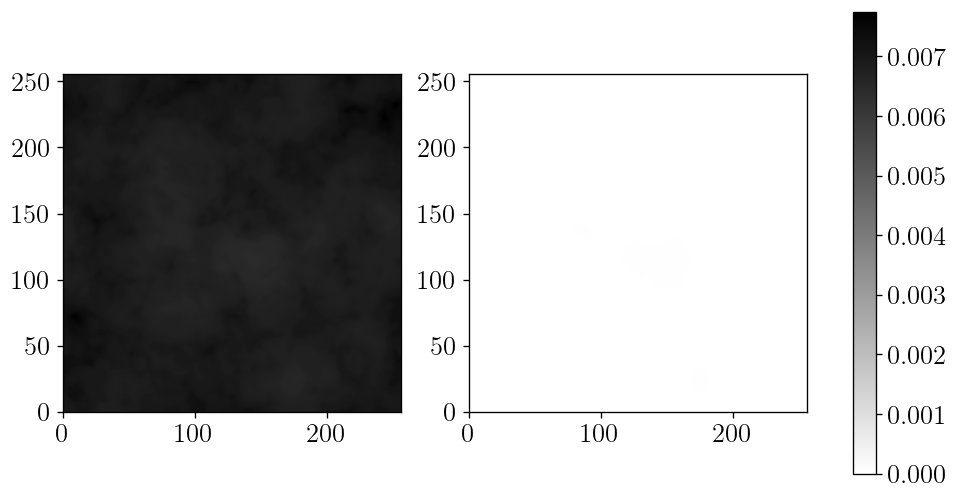

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = 0
vmax = 0.00775
im = axs[0].imshow(xe_box_pc[0], origin='lower', extent=(0, 256, 0, 256), vmin=vmin, vmax=vmax, cmap='binary')
axs[1].imshow(xe_box_pc[0] - xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256), vmin=vmin, vmax=vmax, cmap='binary')

fig.colorbar(im, ax=axs)

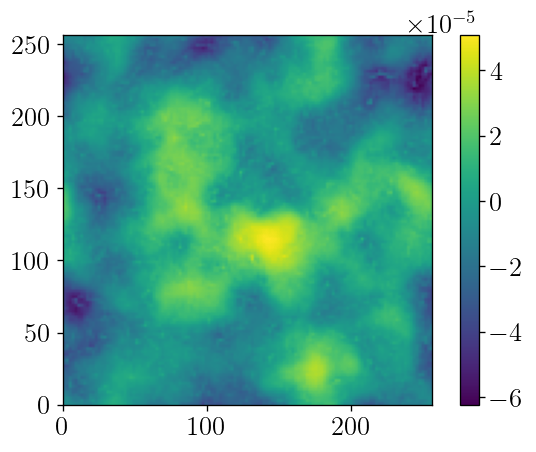

In [15]:
plt.imshow(xe_box_pc[0] - xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256))
plt.colorbar()

In [20]:
p_k_pc, k_bins = pbox.get_power(xe_box_pc, 256)
p_k_dc, k_bins = pbox.get_power(xe_box_dc, 256)

In [21]:
p_k_pc - p_k_dc

array([-3.39976123e-02, -1.27562318e-04, -2.23839312e-05, -5.66255147e-06,
       -1.75524841e-06, -6.48065122e-07, -2.61590414e-07, -1.00842058e-07,
       -4.12775900e-08, -1.57735446e-08,  2.09514749e-09,  2.99622880e-09,
        4.79859149e-09,  5.99776791e-09,  5.51697072e-09,  4.94783955e-09,
        4.58531328e-09,  3.00523579e-09,  3.04480340e-09,  2.11676580e-09,
        1.57682418e-09,  1.53501698e-09,  1.12420230e-09,  8.25931861e-10,
        7.33274975e-10,  6.26906569e-10,  4.49492994e-10,  3.42105098e-10,
        2.97434279e-10,  2.51694485e-10,  1.85141493e-10,  1.46079376e-10,
        1.20671770e-10,  1.08840822e-10,  8.58799376e-11,  6.19035147e-11,
        4.76360890e-11,  3.69345518e-11,  3.07389915e-11,  2.48874119e-11,
        1.90221110e-11,  1.45477271e-11,  1.16735739e-11,  9.45715535e-12,
        8.04128892e-12,  6.73970639e-12,  5.54715163e-12,  4.02417671e-12,
        2.94607349e-12,  2.35346547e-12,  1.83657471e-12,  1.48772050e-12,
        1.26210365e-12,  

[]

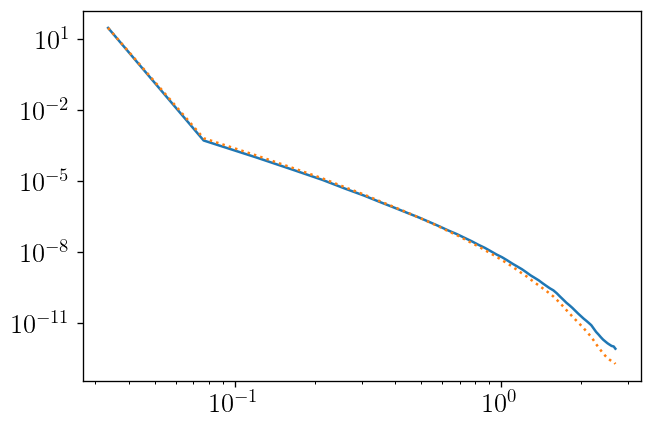

In [22]:
plt.plot(k_bins, p_k_pc)
plt.plot(k_bins, p_k_dc, ':')
plt.loglog()

In [8]:
z = np.array([-0.02454369260617026, 0.0, 0.02454369260617026]) * 1j
z.dtype

dtype('complex128')

In [ ]:
BOX_LEN = 256
n_psbins = 50

power, k = compute_power(
    Tk_box_pc,
    (BOX_LEN, BOX_LEN, BOX_LEN+0.001),
    n_psbins,
    log_bins=True,
)

In [59]:
np.exp(1j)

(0.5403023058681398+0.8414709848078965j)